In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
import matplotlib.pyplot as plt

In [ ]:
#export
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [ ]:
# default_exp local_feature_importance

# TODOs

- Add factory class which prepares object for XGBoost and LightGBM.
- Add example for classification example.

# Local Feature Importance

> Give GBDT model ( XGBoost or LightGBM ) and a specific instance this class would calculate the relationship of different features with a specific instance.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class XGBoostLFI:
    "Wrapper around for `XGBoost` models"
    def __init__(self, model):
        self.model = model
        
    def get_tree(self, trees, tree_index):
        "Return tree for a specific index."
        mask = trees.Tree == tree_index
        return trees.loc[mask]
    
    def get_booster(self): 
        "Returns booster."
        return self.model.get_booster()
    
    def get_num_trees(self, trees_df): 
        "Returns number of number of estimators."
        return trees_df.Tree.nunique()
    
    def get_node(self, tree, node_id):
        "Returns a particular node in a tree."
        mask = tree.ID == node_id
        return tree.loc[mask]
    
    def get_node_index(self, node, branch):
        "Returns index of a particular node in a tree."
        if branch == 'left': return node['Yes'].values[0]
        else: return node['No'].values[0]
        
    def get_node_id(self, node): 
        "Returns id of a particular node in a tree. It is different from a node-index."
        return node['ID'].values[0]
        
    def next_node(self, tree, curr_node, branch):
        "Returns next node from a current node based on which sub-branch one wants to navigate."
        if branch == 'left': return self.get_node(tree, self.get_node_index(curr_node, branch))
        else: return self.get_node(tree, self.get_node_index(curr_node, branch))
    
    def get_split(self, node): 
        "Returns split value"
        return node['Split'].values[0]
    
    def get_feature(self, node): 
        "Returns feature that was used to make the split."
        return node['Feature'].values[0]
    
    def node_score(self, node): 
        "Returns gain for a particular decision node."
        return node['Gain'].values[0]
    
    def node_parent_score(self, node): 
        "Returns parent score for a particular node"
        return node['Parent_Score'].values[0]
    
    def node_cover(self, node): 
        "Returns how many samples are there in a terminal node."
        return node['Cover'].values[0]
    
    def average(self, left_node, right_node):
        "Returns average of scores of children of a node."
        return (left_node['score'] + right_node['score']) / 2
    
    def weighted_sum(self, left_node, right_node):
        "Returns weighted average of children of a node."
        return ((left_node['cover'] * left_node['score'] + right_node['cover'] * right_node['score'])) /\
                (left_node['cover'] + right_node['cover'])
    
    def propagation_strategy(self, left_node, right_node, strategy='average'):
        "Returns parent score from left and right children. It is based on propagation strategy."
        if strategy == 'average': return self.average(left_node, right_node)
        else: return self.weighted_sum(left_node, right_node)

In [ ]:
#export
class LocalFeatureImportance:
    "Calculates `Feature Importance` and provides explanability. It implements (http://www.cs.sjtu.edu.cn/~kzhu/papers/kzhu-infocode.pdf)"
    def __init__(self, model, strategy='average'):
        self.strategy = strategy
        model_category = self.get_model_category(self.get_model_type(model))
        
        if model_category == 'xgboost':
            self.model = XGBoostLFI(model)
    
    def trees_to_df(self):
        "Convert internal tree reprensentation to a Pandas DataFrame"
        if self.get_model_type(self.model) == xgb.core.Booster: return self.model.trees_to_dataframe()
        else: return self.model.get_booster().trees_to_dataframe()
    
    def get_model_type(self, model):
        return type(model)
    
    def get_model_category(self, model_type):
        if model_type in [xgb.core.Booster, xgb.sklearn.XGBRegressor, xgb.sklearn.XGBClassifier]:
            return 'xgboost'
        else:
            raise ValueError(f'{model_type} is not supported.')
    
    def make_node(self, node):
        "Create dict representation of a node which contains score and cover based on strategy."
        if self.strategy == 'average': return {'score': self.model.node_parent_score(node)}
        else: return {'score': self.model.node_parent_score(node), 'cover': self.model.node_cover(node)}
    
    def parse(self, tree, node_id):
        "Calculates and assigns scores for a particular node in the tree."
        current_node = self.model.get_node(tree, node_id)
        
        if self.model.get_feature(current_node) == 'Leaf': return self.model.node_score(current_node)
        
        left_child  = self.model.next_node(tree, current_node, branch='left')
        right_child = self.model.next_node(tree, current_node, branch='right')
        
        left_branch_score = self.parse(tree, self.model.get_node_id(left_child))
        tree.loc[tree.ID == left_child.ID.values[0], 'Parent_Score'] = left_branch_score

        right_branch_score = self.parse(tree, self.model.get_node_id(right_child))
        tree.loc[tree.ID == right_child.ID.values[0], 'Parent_Score'] = right_branch_score
        
        root_score = self.model.propagation_strategy(self.make_node(self.model.get_node(tree,
                                                                                self.model.get_node_index(current_node, branch='left')
                                                                               )),
                                                     self.make_node(self.model.get_node(tree,
                                                                                    self.model.get_node_index(current_node, branch='right')
                                                                               )))
        
        tree.loc[tree.ID == current_node.ID.values[0], 'Parent_Score'] = root_score
        return root_score
        
    def propagate_scores(self):
        "Parse and calculates scores for all nodes for all trees."
        trees_df = self.trees_to_df()
        parsed_trees = []
        num_trees = self.model.get_num_trees(trees_df)
        
        for tree_index in range(num_trees):
            tree = self.model.get_tree(trees_df, tree_index)
            self.parse(tree, f'{tree_index}-0')
            parsed_trees.append(tree)
        
        return pd.concat(parsed_trees, axis=0)
    
    def split_decision(self, feature, split_value):
        "How to decide whether to go left or right in a tree."
        if pd.isnull(feature): return True
        elif feature <= split_value: return True
        else: return False
    
    def walk(self, tree, node_id, test, feature_contribution):
        "Walks through the tree for a specific instance and returns relationship between features and instance."
        current_node = self.model.get_node(tree, node_id)
        feature = self.model.get_feature(current_node)
        
        if feature == 'Leaf': return

        if self.split_decision(test[feature].values[0], self.model.get_split(current_node)):
            left_child = self.model.next_node(tree, current_node, branch='left')
            
            t = self.model.node_parent_score(left_child) - self.model.node_parent_score(current_node)
            feature_contribution[feature].append(t)
            self.walk(tree, self.model.get_node_id(left_child), test, feature_contribution)
        else:
            right_child = self.model.next_node(tree, current_node, branch='right')
            
            t = self.model.node_parent_score(right_child) - self.model.node_parent_score(current_node)
            feature_contribution[feature].append(t)
            self.walk(tree, self.model.get_node_id(right_child), test, feature_contribution)
            
        return feature_contribution
    
    def index_to_feat(self, feats):
        "Maps indices to features."
        return {i:f for i, f in enumerate(feats)}
    
    def get_fi(self, trees, x_test):
        "Calculates feature importance by aggregating over all samples over all trees."
        itof = self.index_to_feat(x_test.columns.tolist())
        fc_over_sample = np.zeros(shape=(x_test.shape[1], x_test.shape[0]))
        
        for index in range(x_test.shape[0]):
            num_trees = self.model.get_num_trees(trees)
            contribution = defaultdict(int)
                
            for tree_index in range(num_trees):
                feature_contribution = defaultdict(list)
                tree = self.model.get_tree(trees, tree_index)
                
                fc = self.walk(tree, f'{tree_index}-0', x_test[index:index+1], feature_contribution)
                
                for f, l in fc.items():
                    contribution[f] += (np.sum(l) / num_trees)
            
            fc_over_sample[:, index] = np.array([contribution[itof[i]] if itof[i] in contribution else 0 for i in range(x_test.shape[1])])
        
        fc_overall = np.apply_along_axis(np.median, axis=1, arr=fc_over_sample)
        return pd.DataFrame({'feature': x_test.columns.tolist(), 'importance': fc_overall})

## Usage

In [ ]:
x,y = make_regression(n_samples=1000,n_features=6,n_informative=3)
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.5, random_state=41)

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=4)
model.fit(xtr,ytr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

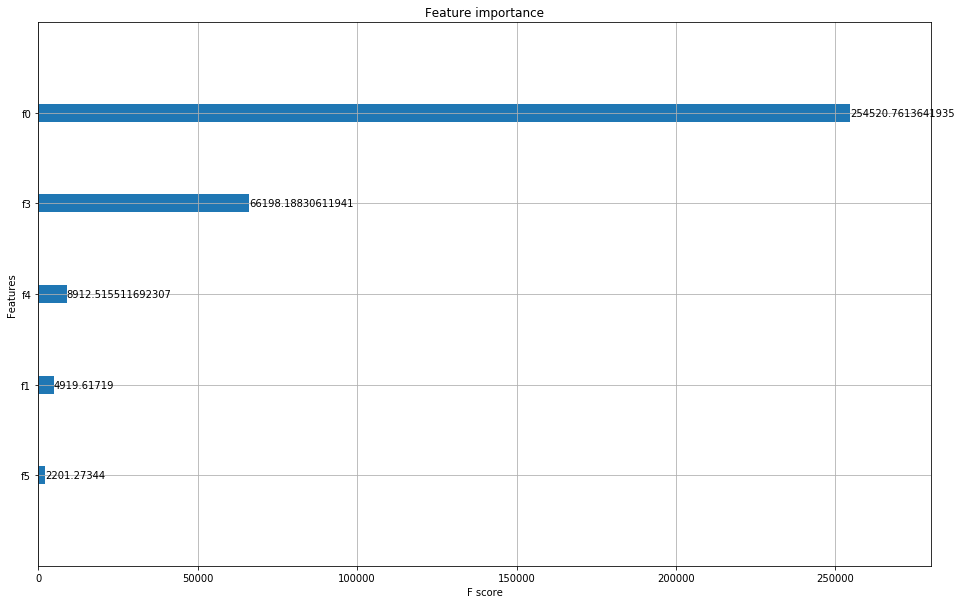

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))
xgb.plot_importance(model, importance_type='gain', ax=ax);

In [ ]:
lfi     = LocalFeatureImportance(model)
scores  = lfi.propagate_scores()

In [ ]:
scores.head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Parent_Score
0,0,0,0-0,f0,-0.159498,0-1,0-2,0-1,2241794.750,500.0,-1.365281
1,0,1,0-1,f0,-1.221669,0-3,0-4,0-3,273895.750,216.0,-8.216369
2,0,2,0-2,f0,0.769237,0-5,0-6,0-5,611977.812,284.0,5.485807
3,0,3,0-3,f3,0.496709,0-7,0-8,0-7,48393.500,60.0,-11.909896
4,0,4,0-4,f3,-0.085148,0-9,0-10,0-9,229686.094,156.0,-4.522841


**Sample instance**

In [ ]:
si = pd.DataFrame(xval[5:6, :], columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5']); si

,f0,f1,f2,f3,f4,f5
0,-1.888674,-1.892477,-2.43059,-1.566565,-0.013852,0.978406


In [ ]:
model.predict(si)

array([-115.28766], dtype=float32)

In [ ]:
fc = lfi.get_fi(scores, si)

In [ ]:
fc

,feature,importance
0,f0,-8.063674
1,f1,0.000000
2,f2,0.000000
3,f3,-2.469592
4,f4,-0.448579
5,f5,-0.596409


### Compare with global feature importance

In [ ]:
x,y = make_regression(n_samples=1000,n_features=6,n_informative=3)
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.5, random_state=41)

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=2)
model.fit(xtr,ytr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

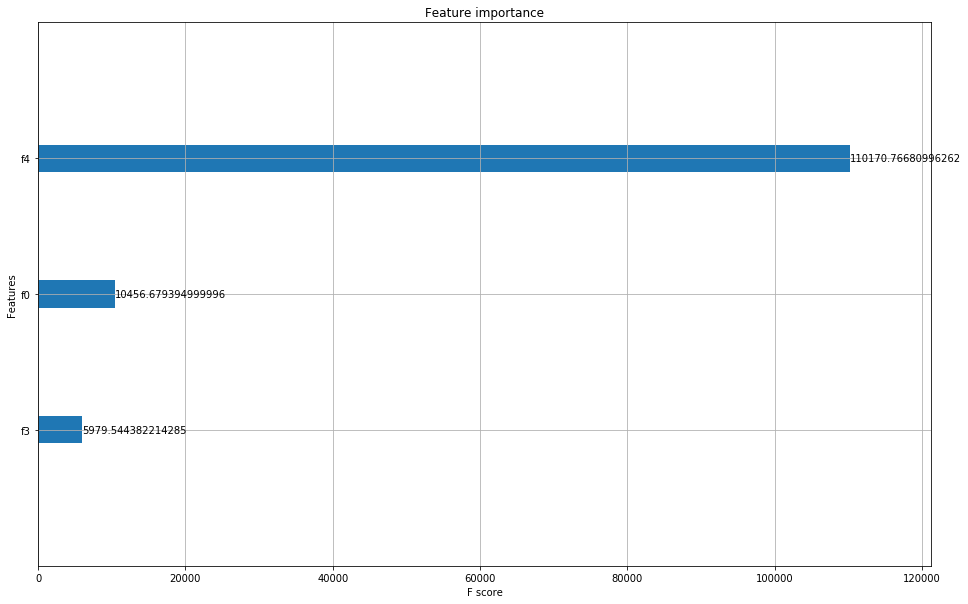

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))
xgb.plot_importance(model, importance_type='gain', ax=ax);

In [ ]:
lfi     = LocalFeatureImportance(model)
scores  = lfi.propagate_scores()

In [ ]:
fc = lfi.get_fi(scores, pd.DataFrame(xval, columns=[f'f{i}' for i in range(6)]))

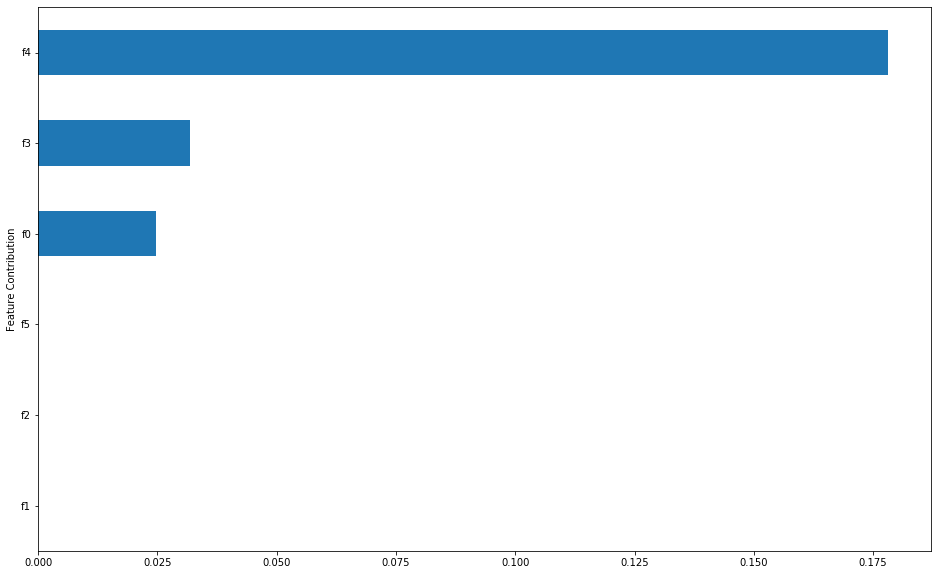

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))

fc.reindex(fc.importance.abs().sort_values(ascending=True).index).set_index('feature')['importance']\
  .map(np.abs).plot(kind='barh', ax=ax)
plt.ylabel('Feature Contribution');